In [1]:
import os
print(os.getcwd())   # shows current directory

/home/njm12/ATMS_596


In [2]:
!pip install geopandas pandas geodatasets matplotlib

In [35]:
import geopandas as gpd
import glob
import pandas as pd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

In [4]:
# Base directory
base_path = "/home/njm12/ATMS_596/Land-Water"

In [5]:
# Recursively find all shapefiles inside Pool folders
shapefiles = glob.glob(base_path + "/**/*27.shp", recursive=True)

gdfs = []
for shp in shapefiles:
    try:
        gdf = gpd.read_file(shp)

        # Fix invalid geometries safely
        gdf = gdf[gdf.is_valid].copy()
        gdf["geometry"] = gdf["geometry"].buffer(0)

    except Exception as e:
        print(f" Error loading {shp}: {e}")
        
    if gdf.crs is None:  # To assign crs to those that do not have one; if we look at the ones that do for your 27 data, they are all 26715, I would guess...
         # For 83 data, change this to 26915
        gdf = gdf.set_crs(epsg=26715)

        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)
print(f" Loaded {len(umesc_all)} features from {len(gdfs)} shapefiles")

 Loaded 3979 features from 9 shapefiles


In [13]:
# --- Step 2: Download TIGER/Line State Boundaries (2023, since 2022 is broken) ---
tiger_url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
r = requests.get(tiger_url)

print("Downloaded size:", len(r.content)/1e6, "MB")

Downloaded size: 9.947818 MB


In [14]:
# Extract zip
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("tl_2023_us_state")

In [15]:
# Load shapefile
states = gpd.read_file("tl_2023_us_state/tl_2023_us_state.shp")
print(states.head())
print("States CRS:", states.crs)

  REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ STUSPS           NAME  \
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
1      3        5      12  00294478    12  0400000US12     FL        Florida   
2      2        3      17  01779784    17  0400000US17     IL       Illinois   
3      2        4      27  00662849    27  0400000US27     MN      Minnesota   
4      3        5      24  01714934    24  0400000US24     MD       Maryland   

  LSAD  MTFCC FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0   00  G4000        A   62266499712    489003081  +38.6472854  -080.6183274   
1   00  G4000        A  138963763779  45970528648  +28.3989775  -082.5143005   
2   00  G4000        A  143778366814   6216688589  +40.1028754  -089.1526108   
3   00  G4000        A  206244555303  18937471947  +46.3159573  -094.1996043   
4   00  G4000        A   25151736098   6979330958  +38.9466584  -076.6744939   

                                      

In [16]:
# --- Step 3: Filter Illinois ---
illinois = states[states["NAME"] == "Illinois"].to_crs("EPSG:26715")

In [18]:
# --- Step 4: Extract Water Polygons Only ---
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()

# Clip water polygons to Illinois boundary
water_il = gpd.clip(water_only, illinois)

# Save clipped result
water_il.to_file("Illinois_Water.shp")

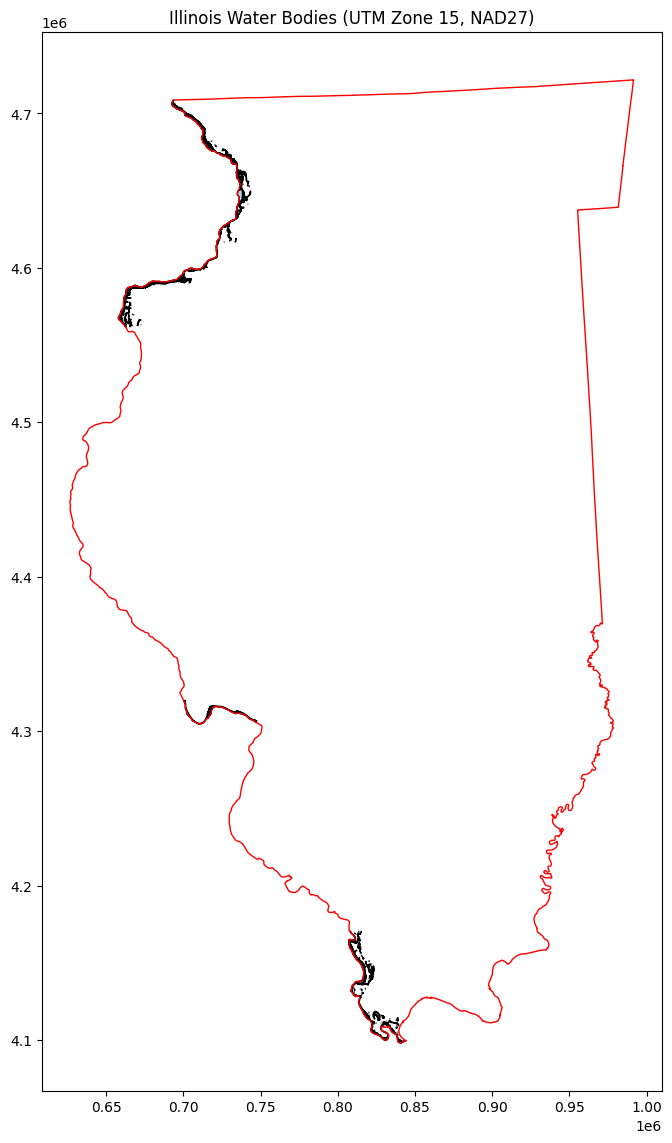

In [19]:
# --- Step 5: Plot Illinois Water in UTM (EPSG:26715) ---
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
plt.title("Illinois Water Bodies (UTM Zone 15, NAD27)")
plt.show()

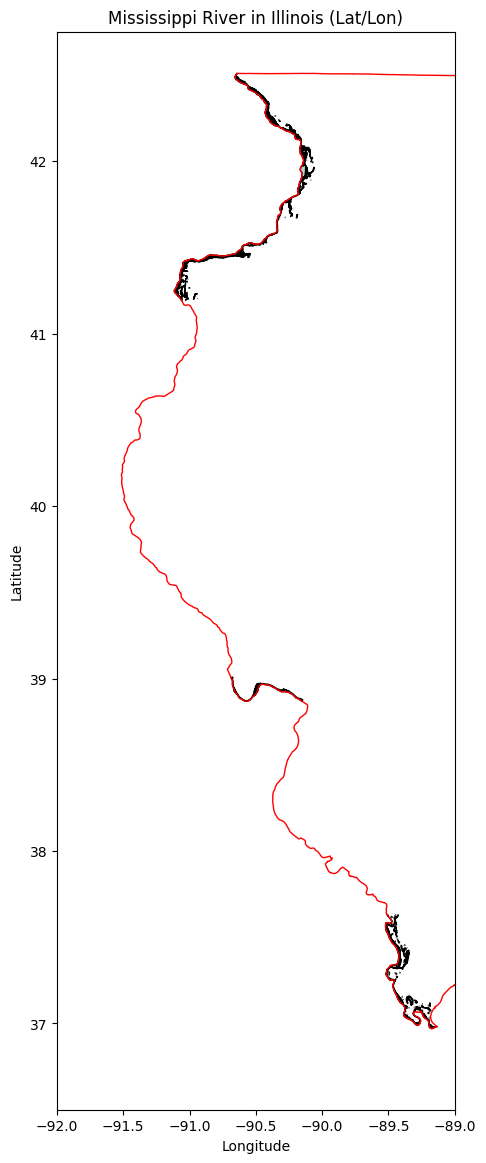

In [21]:
# --- Step 6: Reproject to Lat/Lon (EPSG:4326) ---
water_il_ll = water_il.to_crs(epsg=4326)
illinois_ll = illinois.to_crs(epsg=4326)

# Plot with geographic coords
ax = water_il_ll.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois_ll.boundary.plot(ax=ax, color="red", linewidth=1)

# Set manual bounds for Illinois
ax.set_xlim(-92, -89)
ax.set_ylim(36.5, 42.75)

# Label axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Mississippi River in Illinois (Lat/Lon)")
plt.show()

In [23]:
#base_dir = "/home/njm12/ATMS_596/Land-Water"
#
# Look for shapefiles in subfolders
#shapefiles = glob.glob(os.path.join(base_dir, "**", "*.shp"), recursive=True)
#
#print(f"Found {len(shapefiles)} shapefiles:")
#for shp in shapefiles:
#    print(shp)

In [40]:
# Pools 12–26, excluding 23, plus "Open River"
pools = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26]
pool_dirs = [f"Pool {p}" for p in pools] + ["Open River"]

# Target CRS
target_crs = "EPSG:26715"

gdfs = []
for pool_dir in pool_dirs:
    # Only grab z15n27 shapefiles
    shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
    if not shp_files:
        print(f"⚠️ No z15n27 shapefile found for {pool_dir}")
        continue

    # Read shapefile
    gdf = gpd.read_file(shp_files[0])

    # If CRS missing, assign it (based on your dataset knowledge)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=26715)

    # Reproject to target CRS (safe now)
    gdf = gdf.to_crs(target_crs)

    # Add pool tag
    gdf["POOL"] = pool_dir
    gdfs.append(gdf)
    print(f"Loaded {pool_dir}: {shp_files[0]}")


Loaded Pool 12: /home/njm12/ATMS_596/Land-Water/Pool 12/lw_2000_p12_z15n83.shp
Loaded Pool 13: /home/njm12/ATMS_596/Land-Water/Pool 13/lw_2000_p13_z15n83.shp
Loaded Pool 14: /home/njm12/ATMS_596/Land-Water/Pool 14/lw_2000_p14_z15n83.shp
Loaded Pool 15: /home/njm12/ATMS_596/Land-Water/Pool 15/lw_2000_p15_z15n83.shp
Loaded Pool 16: /home/njm12/ATMS_596/Land-Water/Pool 16/lw_2000_p16_z15n83.shp
Loaded Pool 17: /home/njm12/ATMS_596/Land-Water/Pool 17/lw_2000_p17_z15n83.shp
Loaded Pool 18: /home/njm12/ATMS_596/Land-Water/Pool 18/lw_2000_p18_z15n83.shp
Loaded Pool 19: /home/njm12/ATMS_596/Land-Water/Pool 19/lw_2000_p19_z15n83.shp
Loaded Pool 20: /home/njm12/ATMS_596/Land-Water/Pool 20/lw_2000_p20_z15n83.shp
Loaded Pool 21: /home/njm12/ATMS_596/Land-Water/Pool 21/lw_2000_p21_z15n83.shp
Loaded Pool 22: /home/njm12/ATMS_596/Land-Water/Pool 22/lw_2000_p22_z15n83.shp
Loaded Pool 24: /home/njm12/ATMS_596/Land-Water/Pool 24/lw_2000_p24_z15n83.shp
Loaded Pool 25: /home/njm12/ATMS_596/Land-Water/Pool

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(


GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

In [28]:
# Concatenate into one GeoDataFrame
umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)

print(f"Expected {len(pool_dirs)} shapefiles, found {len(gdfs)}")
print(umesc_all.shape)

Expected 15 shapefiles, found 15
(6825, 14)


In [29]:
# --- Step 2: Load Illinois boundary ---
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

In [30]:
# --- Step 3: Filter water polygons only ---
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 142292185.33151999 of field AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 128762085.26914001 of field AREA of feature 1 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 133385844.33843 of field AREA of feature 29 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 131582057.71725 of field AREA of feature 35 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 109097

<Axes: >

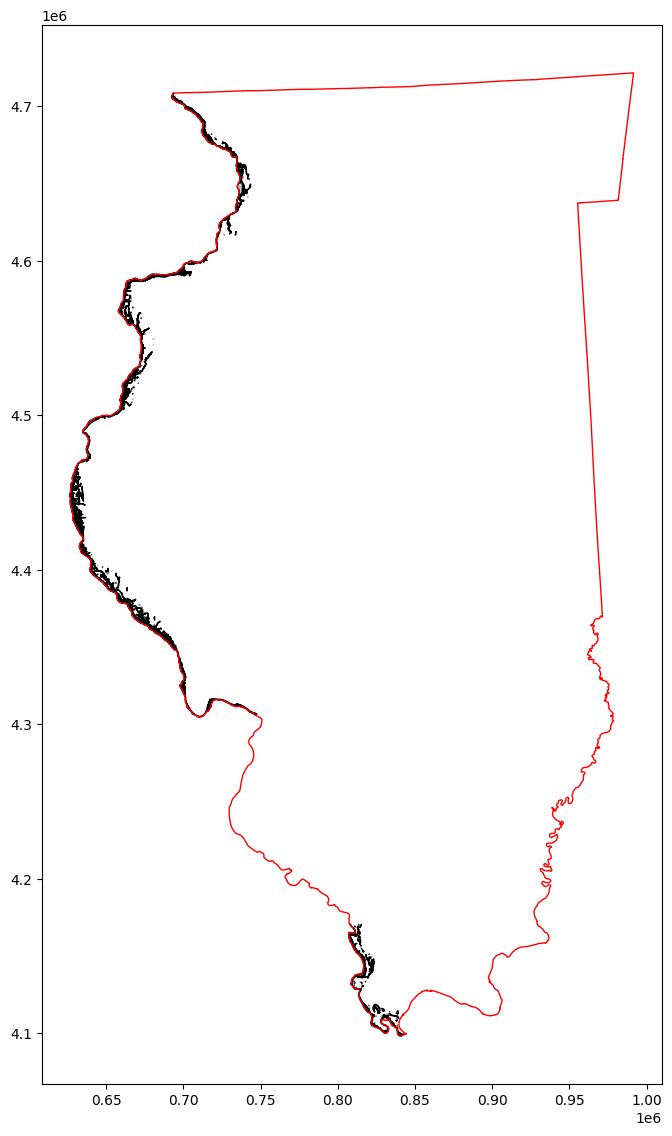

In [33]:
# --- Step 4: Save + plot ---
umesc_all.to_file("All_Pools_15.shp")
water_il.to_file("Illinois_Water.shp")

ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)

In [37]:
target_crs = "EPSG:26715"  # consistent CRS for all pools
gdfs = []

pools = ["Pool 12", "Pool 26", "Open River"]

for pool in pools:
    shp_files = glob.glob(f"/home/njm12/ATMS_596/Land-Water/{pool}/*z15n27.shp")
    for f in shp_files:
        try:
            gdf = gpd.read_file(f)

            # Assign CRS if missing
            if gdf.crs is None:
                gdf = gdf.set_crs(epsg=26715)

            # Transform to target CRS
            gdf = gdf.to_crs(target_crs)

            # Fix invalid geometries
            gdf["geometry"] = gdf["geometry"].buffer(0)

            gdf["POOL"] = pool
            gdfs.append(gdf)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

# Combine all pools
umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)